# Imports

In [3]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
from scipy.signal import savgol_filter
import torch

import matplotlib.pyplot as plt 
import matplotlib as ml
plt.style.use('default')

from biospectools.preprocessing import emsc
from biospectools.utils.interpolate import interp2wns

from models.microcal_models import CalibrationModel
from models.microcal_models import MicroToMacroModel

# Load data

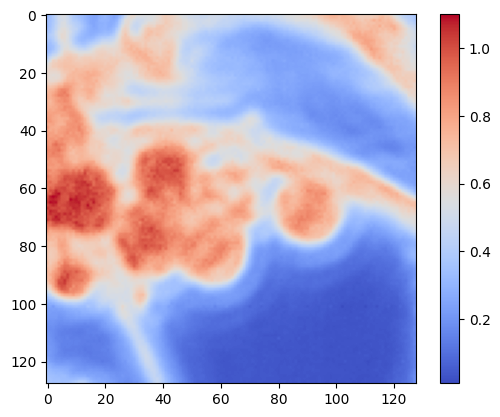

In [42]:
wn = np.load('data/wn.npz')['wn']   # wn range used for models

df = pd.read_csv('data/test.csv')
wn_fungi = df.columns.values.astype('float')
spectra = df.values

spectra, _ = interp2wns(wn_fungi, wn, spectra)
im = spectra.reshape(128, 128, -1)
plt.imshow(im[:, :, np.argmin(np.abs(1745 - wn))], cmap='coolwarm')
plt.colorbar()
plt.show()

# Load model

In [33]:
device = 'cuda'
transfer_model = MicroToMacroModel().float().to(device)
transfer_model.load_state_dict(torch.load(f'weights/scatteredFPAh_to_HTS.t7', weights_only=True))
transfer_model.eval();

# Microcalibration

## Transfer and scatter-correction

In [36]:
with torch.no_grad():
    transferred_im = []
    for i, spec in enumerate(im):
        print(i, end='\r')
        corr_line = []
        for s in spec:
            c = transfer_model(torch.from_numpy(s[None, None, :]).float().to(device))
            corr_line.append(c.detach().cpu().numpy().squeeze())
        transferred_im.append(corr_line)
    transferred_im = np.array(transferred_im)

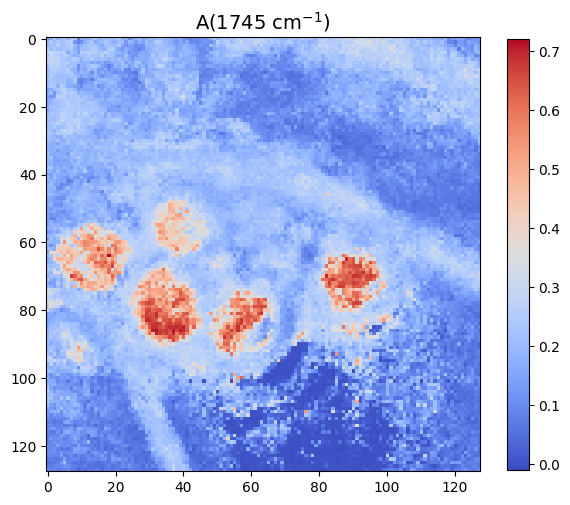

In [37]:
plt.figure(figsize=(7, 7))
plt.imshow(transferred_im[:, :, np.argmin(np.abs(1745 - wn))], cmap='coolwarm')
plt.title(r'A(1745 cm$^{-1}$)', fontsize=14)
plt.colorbar(shrink=0.8)
plt.show()

## Obtain microcalibrated image

In [44]:
def predict_microcal_im(transferred_im, weights_path, device='cuda'):
    mc_model = CalibrationModel(out_layers=1).to(device);
    mc_model.load_state_dict(torch.load(weights_path, weights_only=True))
    mc_model.eval();
    with torch.no_grad():
        mc_im = []
        for i, spec in enumerate(transferred_im):
            print(f' {i} / {transferred_im.shape[0]}   ', end='\r')
            line = []
            for s in spec:
                c = mc_model(torch.from_numpy(s[None, None, :]).float().to(device))
                line.append(c.detach().cpu().numpy().squeeze())
            mc_im.append(line)
    return np.array(mc_im)

In [45]:
lipid_im = predict_microcal_im(transferred_im, 'weights/pred_lipid.t7', device = 'cuda')
ga_im = predict_microcal_im(transferred_im, 'weights/pred_GA.t7', device = 'cuda')
pfa_im = predict_microcal_im(transferred_im, 'weights/pred_PFA.t7', device = 'cuda')
sfa_im = predict_microcal_im(transferred_im, 'weights/pred_SFA.t7', device = 'cuda')

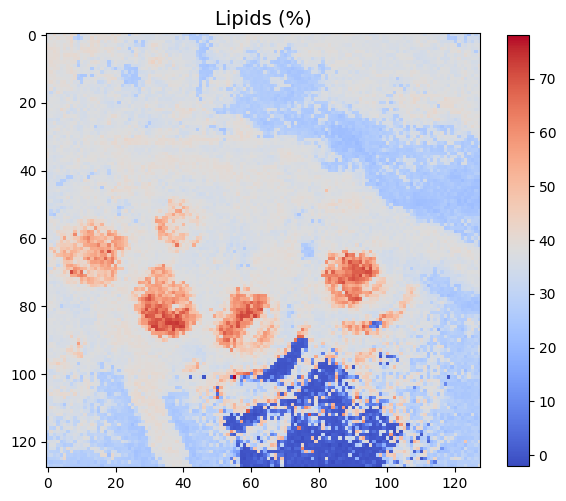

In [46]:
plt.figure(figsize=(7, 7))
plt.imshow(lipid_im, cmap='coolwarm')
plt.title('Lipids (%)', fontsize=14)
plt.colorbar(shrink=0.8)
plt.show()

In [47]:
# filter out background
# disregard pixel with low signals

pwr_mask = (im.mean(axis=-1) < 0.225).reshape(128, 128)

ga_im[pwr_mask] = np.nan
sfa_im[pwr_mask] = np.nan
pfa_im[pwr_mask] = np.nan

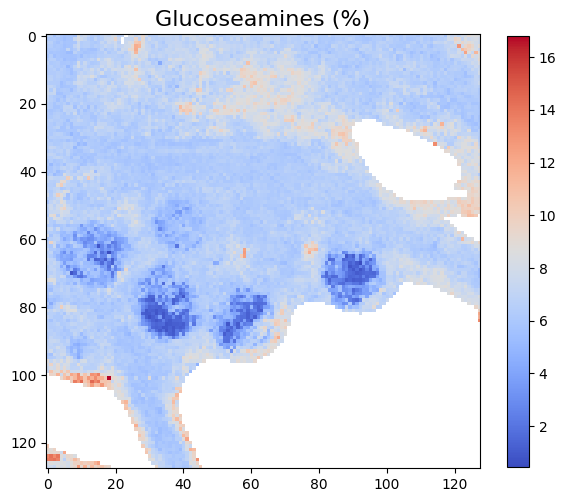

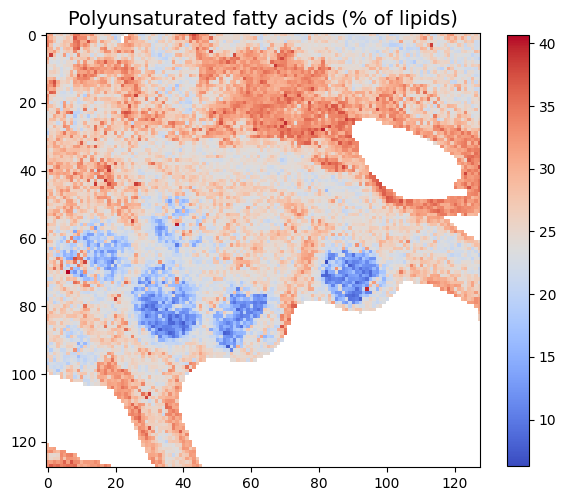

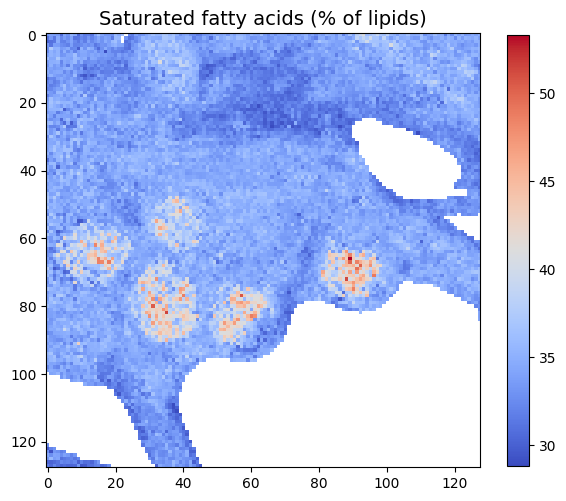

In [48]:
plt.figure(figsize=(7, 7))
plt.imshow(ga_im, cmap='coolwarm')
plt.title('Glucoseamines (%)', fontsize=16)
plt.colorbar(shrink=0.8)
plt.show()

plt.figure(figsize=(7, 7))
plt.imshow(pfa_im, cmap='coolwarm')
plt.title('Polyunsaturated fatty acids (% of lipids)', fontsize=14)
plt.colorbar(shrink=0.8)
plt.show()

plt.figure(figsize=(7, 7))
plt.imshow(sfa_im, cmap='coolwarm')
plt.title('Saturated fatty acids (% of lipids)', fontsize=14)
plt.colorbar(shrink=0.8)
plt.show()